In [1]:
import pandas as pd
import numpy as np
import shap
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
data = yf.download("AAPL", start="2020-01-01", end="2024-03-01")

/Users/hanyuwu/Library/Caches/pypoetry/virtualenvs/compare-multiple-backtests-f1m3Q6xX-py3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [3]:
data["SMA50"] = data["Close"].rolling(window=50).mean()
data["EMA50"] = data["Close"].ewm(span=50, adjust=False).mean()

# RSI
delta = data["Close"].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data["RSI"] = 100 - (100 / (1 + rs))

# MACD
exp1 = data["Close"].ewm(span=12, adjust=False).mean()
exp2 = data["Close"].ewm(span=26, adjust=False).mean()
data["MACD"] = exp1 - exp2

# ATR
high_low = data["High"] - data["Low"]
high_close = (data["High"] - data["Close"].shift()).abs()
low_close = (data["Low"] - data["Close"].shift()).abs()
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = ranges.max(axis=1)
data["ATR"] = true_range.rolling(window=14).mean()

# Bollinger Bands
data["Middle_BB"] = data["Close"].rolling(window=20).mean()
data["Upper_BB"] = data["Middle_BB"] + 2 * data["Close"].rolling(window=20).std()
data["Lower_BB"] = data["Middle_BB"] - 2 * data["Close"].rolling(window=20).std()

# OBV
data["OBV"] = (np.sign(data["Close"].diff()) * data["Volume"]).fillna(0).cumsum()

# VWAP (assuming intraday data is available)
data["VWAP"] = (
    data["Volume"] * (data["High"] + data["Low"] + data["Close"]) / 3
).cumsum() / data["Volume"].cumsum()

In [4]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA50,EMA50,RSI,MACD,ATR,Middle_BB,Upper_BB,Lower_BB,OBV,VWAP
Date,,,,,,,,,,,,,,,,
2024-02-23,185.009995,185.039993,182.229996,182.520004,182.520004,45119700,188.967200,187.007417,40.280199,-1.732956,2.699285,186.306999,192.637860,179.976139,1.144330e+09,130.107913
2024-02-26,182.240005,182.759995,180.649994,181.160004,181.160004,40867400,188.696200,186.778107,30.432210,-1.871174,2.606428,185.743999,191.781818,179.706181,1.103462e+09,130.128583
2024-02-27,181.100006,183.919998,179.559998,182.630005,182.630005,54318900,188.389600,186.615436,29.800120,-1.840875,2.736428,185.289000,190.773654,179.804346,1.157781e+09,130.156305
2024-02-28,182.509995,183.119995,180.130005,181.419998,181.419998,48953900,188.055800,186.411693,27.314011,-1.892683,2.775713,184.958000,190.541751,179.374250,1.108827e+09,130.181033
2024-02-29,181.270004,182.570007,179.529999,180.750000,180.750000,136682600,187.719399,186.189666,27.981366,-1.965152,2.836429,184.775500,190.666199,178.884802,9.721447e+08,130.249135


In [5]:
data["Future_Close"] = data["Close"].shift(-5)  # Shift by 10 days
data["Target"] = data["Future_Close"] > data["Close"].astype(int)
data.head()

,Open,High,Low,Close,Adj Close,Volume,SMA50,EMA50,RSI,MACD,ATR,Middle_BB,Upper_BB,Lower_BB,OBV,VWAP,Future_Close,Target
Date,,,,,,,,,,,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059441,135480400,NaN,75.087502,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,74.678335,77.407501,True
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349121,146322800,NaN,75.058874,NaN,-0.058234,NaN,NaN,NaN,NaN,-146322800.0,74.607803,77.582497,True
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925644,118387200,NaN,75.054604,NaN,-0.055930,NaN,NaN,NaN,NaN,-27935600.0,74.539180,79.239998,True
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582657,108872000,NaN,75.036679,NaN,-0.081607,NaN,NaN,NaN,NaN,-136807600.0,74.580169,78.169998,True
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750252,132079200,NaN,75.066515,NaN,-0.005068,NaN,NaN,NaN,NaN,-4728400.0,74.748887,77.834999,True


In [6]:
X = data.drop(["Target", "Future_Close"], axis=1)
y = data["Target"]

In [7]:
# split train and test by date
X_train = X[X.index < "2023-01-01"]
X_test = X[X.index >= "2023-01-01"]
y_train = y[y.index < "2023-01-01"]
y_test = y[y.index >= "2023-01-01"]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 449, number of negative: 307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4004
[LightGBM] [Info] Number of data points in the train set: 756, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593915 -> initscore=0.380175
[LightGBM] [Info] Start training from score 0.380175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/hanyuwu/Library/Caches/pypoetry/virtualenvs/compare-multiple-backtests-f1m3Q6xX-py3.11/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


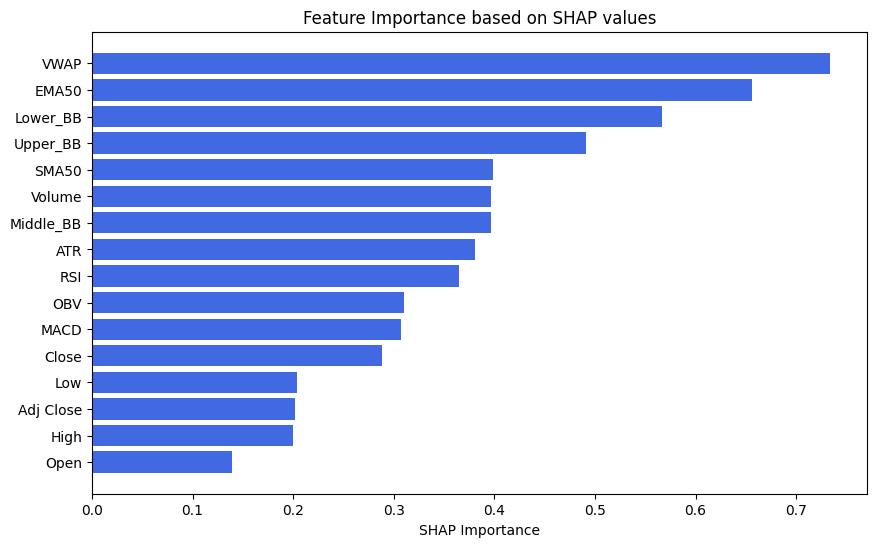

In [8]:
model = LGBMClassifier()
model.fit(X_train, y_train)

# Step 2: Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Assuming binary classification; adjust accordingly for multi-class
expected_value = (
    explainer.expected_value[1]
    if isinstance(explainer.expected_value, list)
    else explainer.expected_value
)
shap_values = shap_values[1] if isinstance(shap_values, list) else shap_values

# Step 3: Summarize SHAP values in a DataFrame
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ["feature", "shap_importance"]
importance_df["shap_importance"] = importance_df["shap_importance"].astype(float)
importance_df = importance_df.sort_values("shap_importance", ascending=False)

# Step 4: Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["feature"], importance_df["shap_importance"], color="royalblue")
plt.xlabel("SHAP Importance")
plt.title("Feature Importance based on SHAP values")
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

In [9]:
fig = px.bar(
    importance_df,
    x="shap_importance",
    y="feature",
    orientation="h",
    title="Feature Importance based on SHAP values",
    color="shap_importance",
    labels={"shap_importance": "SHAP Importance", "feature": ""},
    color_continuous_scale="Blues",
)

fig.update_layout(yaxis={"categoryorder": "total ascending"})

fig.show()

In [10]:
top_10_features = importance_df.sort_values(by="shap_importance", ascending=False).head(
    10
)
selected_features = top_10_features["feature"].tolist()

In [11]:
selected_features

['VWAP',
 'EMA50',
 'Lower_BB',
 'Upper_BB',
 'SMA50',
 'Volume',
 'Middle_BB',
 'ATR',
 'RSI',
 'OBV']

In [12]:
# Assuming `selected_features` are the features selected through some feature selection process
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Initialize and train the model using the selected features
model = LGBMClassifier(random_state=42)
model.fit(X_train_selected, y_train)

[LightGBM] [Info] Number of positive: 449, number of negative: 307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2487
[LightGBM] [Info] Number of data points in the train set: 756, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593915 -> initscore=0.380175
[LightGBM] [Info] Start training from score 0.380175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

LGBMClassifier(random_state=42)

In [13]:
# Predict on the test set
predictions = model.predict(X_test_selected)

# Calculate accuracy or any other performance metrics
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.41237113402061853


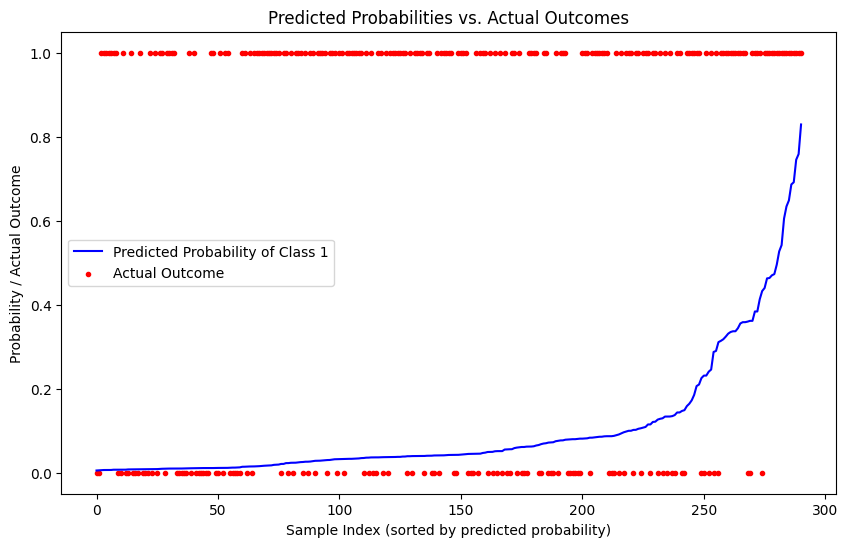

In [14]:
import matplotlib.pyplot as plt

# Predict probabilities for the positive class (e.g., class "1")
probabilities = model.predict_proba(X_test_selected)[:, 1]

# Create a DataFrame to hold actual and predicted values
results_df = pd.DataFrame({"Actual": y_test, "Predicted": probabilities})

# Sort the DataFrame by predicted probabilities for better visualization
results_df = results_df.sort_values(by="Predicted")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(
    results_df["Predicted"].values,
    label="Predicted Probability of Class 1",
    color="blue",
)
plt.scatter(
    range(len(results_df)),
    results_df["Actual"].values,
    marker=".",
    label="Actual Outcome",
    color="red",
)

# Enhancing the plot
plt.title("Predicted Probabilities vs. Actual Outcomes")
plt.xlabel("Sample Index (sorted by predicted probability)")
plt.ylabel("Probability / Actual Outcome")
plt.legend()
plt.show()

In [17]:
import math
import warnings

warnings.filterwarnings("ignore")
from termcolor import colored as cl

In [20]:
def implement_strategy(df, investment):

    in_position = False
    equity = investment

    for i, row in df.iterrows():
        prob_negative, prob_positive = model.predict_proba(
            [row[selected_features].values]
        )[0]
        if prob_positive > 0.7 and in_position == False:
            no_of_shares = math.floor(equity / df.Close[i])
            equity -= no_of_shares * df.Close[i]
            in_position = True
            print(
                cl("BUY: ", color="green", attrs=["bold"]),
                f'{no_of_shares} Shares are bought at ${df.Close[i]} on {str(df["Date"][i])[:10]}',
            )
        elif prob_negative > (1 - 0.3) and in_position == True:
            equity += no_of_shares * df.Close[i]
            in_position = False
            print(
                cl("SELL: ", color="red", attrs=["bold"]),
                f'{no_of_shares} Shares are sold at ${df.Close[i]} on {str(df["Date"][i])[:10]}',
            )
    if in_position == True:
        equity += no_of_shares * df.Close[i]
        print(
            cl(
                f'\nClosing position at {df.Close[i]} on {str(df["Date"][i])[:10]}',
                attrs=["bold"],
            )
        )
        in_position = False

    earning = round(equity - investment, 2)
    roi = round(earning / investment * 100, 2)
    # return roi
    print(cl(f"EARNING: ${earning} ; ROI: {roi}%", attrs=["bold"]))

In [21]:
implement_strategy(X_test.reset_index(), 10000)

BUY:  79 Shares are bought at $125.06999969482422 on 2023-01-03
SELL:  79 Shares are sold at $143.9600067138672 on 2023-01-26
BUY:  79 Shares are bought at $144.2899932861328 on 2023-01-31
SELL:  79 Shares are sold at $154.5 on 2023-02-03
EARNING: $2298.9 ; ROI: 22.99%
